In [ ]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Define the Sobel filter (for detecting edges)
sobel_kernel = torch.tensor([
    [-1.0, 0.0, 1.0],
    [-2.0, 0.0, 2.0],
    [-1.0, 0.0, 1.0]
])

def rotate_reflect_kernel(kernel, angle, reflection):
    """
    Rotates a 3x3 kernel by the given angle using an affine grid transformation.
    """
    reflection=reflection*1
    theta = angle*np.pi/180
    rotation_reflection_matrix = torch.tensor([
        [((-1)**reflection) *np.cos(theta), -((-1)**reflection)*np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0]
    ],dtype=torch.float)

    # Apply the transformation to each pixel coordinate in the 3x3 grid
    grid = F.affine_grid(rotation_reflection_matrix.unsqueeze(0), kernel.unsqueeze(0).unsqueeze(0).size(), align_corners=False)
    new_kernel = F.grid_sample(kernel.unsqueeze(0).unsqueeze(0), grid, align_corners=False)

    return new_kernel.squeeze()


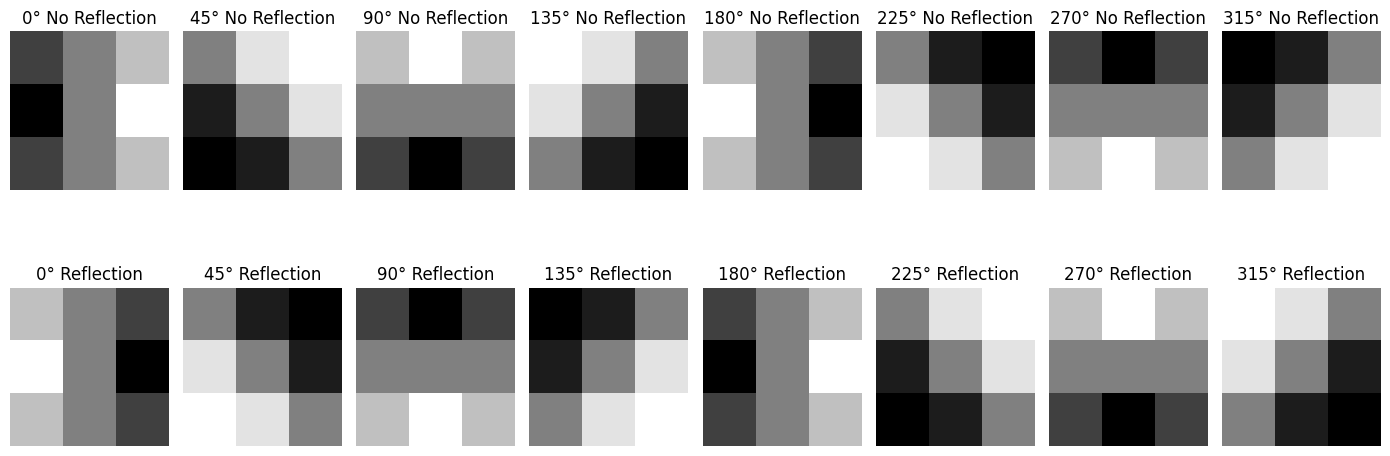

In [ ]:
# Example of rotations and reflections
angles = [0, 45, 90, 135, 180, 225, 270, 315]

# Prepare a tensor to store the 16 transformed kernels (8 rotations + 8 reflections)
group_equivariant_kernels = torch.zeros(size=(16, 3, 3))

# Create the figure and subplots outside the loop
fig, ax = plt.subplots(2, 8, figsize=(14, 6))  # 2 rows, 8 columns

# Loop through angles and apply transformations
for i, angle in enumerate(angles * 2):  # Iterate through angles twice (rotations + reflections)
    if i < 8:
        reflection = False
    else:
        reflection = True

    # Rotate and reflect the kernel
    group_equivariant_kernels[i, :] = rotate_reflect_kernel(sobel_kernel, angle, reflection)

    # Select the subplot to plot the transformed kernel
    row = i // 8  # Determine the row (0 or 1)
    col = i % 8   # Determine the column (0 to 7)

    # Plot the kernel on the corresponding axis
    ax[row, col].imshow(group_equivariant_kernels[i, :].numpy(), cmap='gray')
    ax[row, col].set_title(f'{angle}° {"Reflection" if reflection else "No Reflection"}')
    ax[row, col].axis('off')  # Hide axis ticks for clarity

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 11518170.35it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 343364.87it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 2756742.14it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5608044.97it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Label: 7


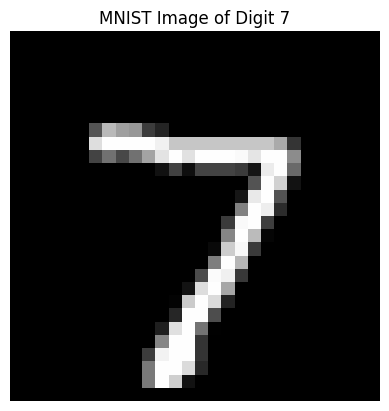

torch.Size([1, 28, 28])


In [ ]:
# Define the transformation to convert images to tensors
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Download and load the MNIST dataset
mnist_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Get a single image and label
image, label = mnist_dataset[0]
print(f"Label: {label}")

# Display the image
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"MNIST Image of Digit {label}")
plt.axis('off')
plt.show()
print(image.shape)

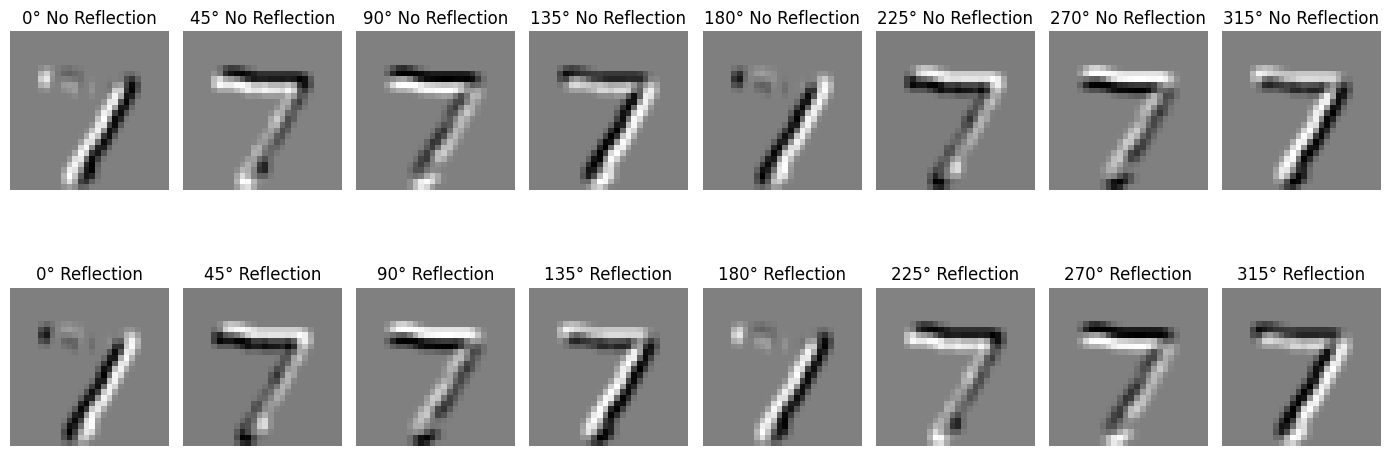

In [ ]:
kernels = group_equivariant_kernels.unsqueeze(1)  # Shape: (16, 1, 3, 3)
# Ensure the image has a batch dimension
test_image = image.unsqueeze(0)  # Shape: (1, 1, 28, 28)
# Perform convolution with each kernel
outputs_tensor = F.conv2d(test_image, kernels, padding=1).squeeze()

fig, ax = plt.subplots(2, 8, figsize=(14, 6))  # 2 rows, 8 columns
for i in range(outputs_tensor.shape[0]):  # Iterate through angles twice (rotations + reflections)
    if i < 8:
        reflection = False
    else:
        reflection = True
    # Select the subplot to plot the response of the convolution
    row = i // 8  # Determine the row (0 or 1)
    col = i % 8   # Determine the column (0 to 7)

    # Plot the response on the corresponding axis
    ax[row, col].imshow(outputs_tensor[i, :].numpy(), cmap='gray')
    ax[row, col].set_title(f'{i*45 % 360}° {"Reflection" if reflection else "No Reflection"}')
    ax[row, col].axis('off')  # Hide axis ticks for clarity

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

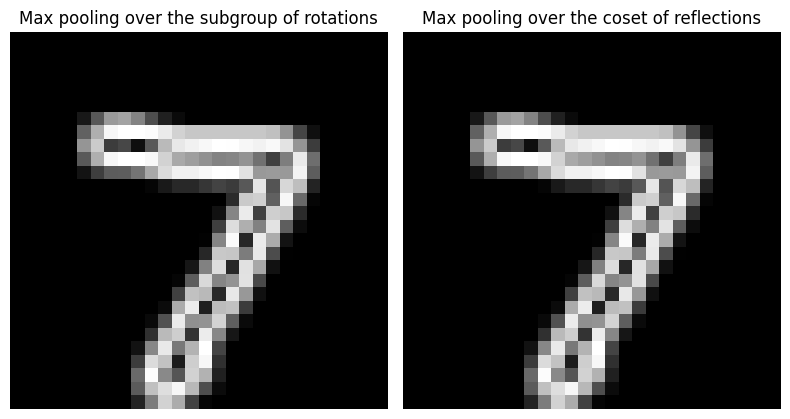

In [ ]:
# Separate rotation and reflection outputs
rotation_outputs = outputs_tensor[:8]    # First 8 are rotations
reflection_outputs = outputs_tensor[8:]  # Next 8 are reflections

# subgroup pooling over rotations
subgroup_pooled_output_rotations, _ = torch.max(rotation_outputs, dim=0)  # Shape: (1, 28, 28)

# Coset pooling over reflections
coset_pooled_output_reflections, _ = torch.max(reflection_outputs, dim=0)


fig, ax = plt.subplots(1, 2, figsize=(8, 20))  # 1 row, 2 columns
#plot each pooling response
ax[0].imshow(subgroup_pooled_output_rotations.numpy(), cmap='gray')
ax[0].set_title(f'Max pooling over the subgroup of rotations')
ax[0].axis('off')  # Hide axis ticks for clarity

#plot each pooling response
ax[1].imshow(subgroup_pooled_output_rotations.numpy(), cmap='gray')
ax[1].set_title(f'Max pooling over the coset of reflections')
ax[1].axis('off')  # Hide axis ticks for clarity
# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms.functional import rotate, vflip

class GroupCNN(nn.Module):
    def __init__(self):
        super(GroupCNN, self).__init__()

        # Define the base learnable 3x3 kernel
        self.base_kernel = nn.Parameter(torch.normal(mean=torch.zeros(1, 1, 3, 3),std=1))  # Single 3x3 kernel to be extended

        # Define a learnable bias for each of the 16 kernels
        self.biases = nn.Parameter(torch.normal(mean=torch.zeros(16),std=1))  # One bias term per group element

        # Leaky ReLU
        self.leaky_relu1 = nn.LeakyReLU(negative_slope=0.01, inplace=True)

        # Pooling and fully connected layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(2 * 14 * 14, 10)  # Adjust for 2x 14x14 after pooling

    def extend_kernels(self, kernel):
        """ Extend the base kernel to 16 group transformations """
        kernels = []

        # First 8 kernels: rotations (0°, 45°, 90°, ..., 315°)
        for angle in range(0, 360, 45):
            rotated_kernel = rotate(kernel, angle=angle)
            kernels.append(rotated_kernel)

        # Next 8 kernels: reflection and then rotations
        reflected_kernel = vflip(kernel)
        for angle in range(0, 360, 45):
            rotated_reflected_kernel = rotate(reflected_kernel, angle=angle)
            kernels.append(rotated_reflected_kernel)

        return torch.stack(kernels).squeeze(1)

    def forward(self, x):
        # Get 16 transformed kernels
        extended_kernels = self.extend_kernels(self.base_kernel)

        # Perform convolution manually for each kernel, with bias
        conv_outputs = []
        for i in range(16):
            conv_out = F.conv2d(x, extended_kernels[i].unsqueeze(0), padding=1)
            conv_out += self.biases[i]  # Add bias to each convolution
            conv_outputs.append(conv_out)

        # Concatenate along the channel dimension (like applying 16 filters)
        x = torch.cat(conv_outputs, dim=1)

        # Apply the Leaky ReLU activation
        x = self.leaky_relu1(x)

        # Group pooling and coset pooling
        rotation_outputs = x[:, :8]  # First 8 channels for rotations
        reflection_outputs = x[:, 8:]  # Next 8 channels for reflections

        # Subgroup pooling over rotations
        subgroup_pooled_output_rotations, _ = torch.max(rotation_outputs, dim=1)

        # Coset pooling over reflections
        coset_pooled_output_reflections, _ = torch.max(reflection_outputs, dim=1)

        # Combine the outputs after pooling
        x = torch.cat((subgroup_pooled_output_rotations, coset_pooled_output_reflections), dim=1)

        # Apply spatial max pooling (reduce to 14x14)
        x = self.pool(x.unsqueeze(1))

        # Flatten before fully connected layers
        x = x.view(x.size(0), -1)

        # Fully connected layer
        x = self.fc1(x)

        return x


In [ ]:
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split

# Step 1: Load the Fashion-MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to grayscale (1 channel) by default
    transforms.Normalize((0.5,), (0.5,))  # Normalizing to [-1, 1] range
])

train_data = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_data = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Step 3: Instantiate the network
model = GroupCNN()

# Step 4: Define loss and optimizer
criterion = nn.CrossEntropyLoss()  # This includes softmax internally
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop (example)
def train(model, train_loader, optimizer, criterion, epochs=16):
    model.train()
    for epoch in range(epochs):
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Step 5: Train the model
train(model, train_loader, optimizer, criterion)

Epoch 1, Loss: 0.40862780809402466
Epoch 2, Loss: 0.3365539312362671
Epoch 3, Loss: 0.6542624235153198
Epoch 4, Loss: 0.5197820663452148
Epoch 5, Loss: 0.29064974188804626
Epoch 6, Loss: 0.6875016689300537
Epoch 7, Loss: 0.497249960899353
Epoch 8, Loss: 0.3387093245983124
Epoch 9, Loss: 0.28471043705940247
Epoch 10, Loss: 0.5286751985549927
Epoch 11, Loss: 0.3000281751155853
Epoch 12, Loss: 0.1277100294828415
Epoch 13, Loss: 0.28033629059791565
Epoch 14, Loss: 0.7241425514221191
Epoch 15, Loss: 0.4409535229206085
Epoch 16, Loss: 0.4618646502494812


In [ ]:
def evaluate_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation
        for images, labels in test_loader:
            # Forward pass
            outputs = model(rotate(images,60*torch.rand(1).item()))
            # Compute the loss
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Get predictions from the outputs
            _, predicted = torch.max(outputs, 1)

            # Update total and correct predictions count
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate the overall accuracy and average test loss
    accuracy = 100 * correct / total
    avg_test_loss = test_loss / len(test_loader)

    print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

    return avg_test_loss, accuracy

test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)

Test Loss: 3.3414, Test Accuracy: 39.24%


In [ ]:
equivariant_kernel=model.base_kernel

In [ ]:
class NormalCNN(nn.Module):
    def __init__(self):
        super(NormalCNN, self).__init__()

        # Manually initialized kernels, not learnable
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, padding=1,)


        # Initialize weights using torch.normal with a mean of 0 and std of 1
        self.conv1.weight.data = torch.normal(mean=torch.zeros(2, 1, 3, 3),std=1)

        self.conv1.bias.data = torch.normal(mean=torch.zeros(2),std=1)

        # Learnable Leaky ReLU parameter
        self.leaky_relu1 = nn.LeakyReLU(negative_slope=0.01, inplace=True)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(2 * 14 * 14, 10) # 10 output classes

    def forward(self, x):
        x = self.conv1(x)  # Apply manual kernels
        x = self.leaky_relu1(x)  # Apply learnable Leaky ReLU

        x = self.pool(x)  # Apply spatial max pooling (reduce to 14x14)

        # Flatten before fully connected layers
        x = x.view(x.size(0), -1)  # Ensure correct batch size

        x = self.fc1(x)

        return x


In [ ]:
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split

# Step 1: Load the Fashion-MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to grayscale (1 channel) by default
    transforms.Normalize((0.5,), (0.5,))  # Normalizing to [-1, 1] range
])

train_data = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_data = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Step 3: Instantiate the network
model = NormalCNN()

# Step 4: Define loss and optimizer
criterion = nn.CrossEntropyLoss()  # This includes softmax internally
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop (example)
def train(model, train_loader, optimizer, criterion, epochs=16):
    model.train()
    for epoch in range(epochs):
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Step 5: Train the model
train(model, train_loader, optimizer, criterion)

Epoch 1, Loss: 0.7017806768417358
Epoch 2, Loss: 0.678337037563324
Epoch 3, Loss: 0.24818184971809387
Epoch 4, Loss: 0.22971540689468384
Epoch 5, Loss: 0.29133638739585876
Epoch 6, Loss: 0.2691892981529236
Epoch 7, Loss: 0.3065755367279053
Epoch 8, Loss: 0.22192077338695526
Epoch 9, Loss: 0.16717763245105743
Epoch 10, Loss: 0.23633919656276703
Epoch 11, Loss: 0.2951669692993164
Epoch 12, Loss: 0.456632524728775
Epoch 13, Loss: 0.35454386472702026
Epoch 14, Loss: 0.17071785032749176
Epoch 15, Loss: 0.5145950317382812
Epoch 16, Loss: 0.3116227388381958


In [ ]:
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)

Test Loss: 3.5392, Test Accuracy: 42.93%


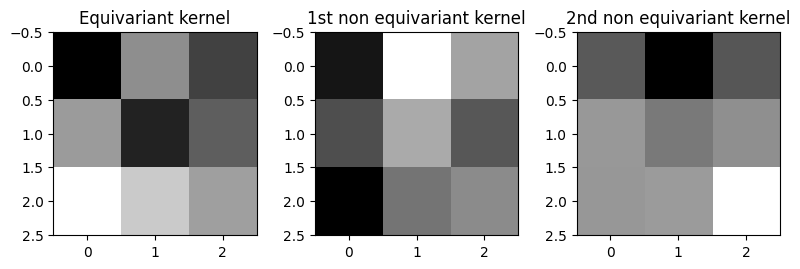

In [ ]:
non_equivariant_kernel=model.conv1.weight.data

fig, ax = plt.subplots(1, 3, figsize=(8, 20))  # 1 row, 2 columns
ax[0].imshow(equivariant_kernel.data.squeeze().numpy(), cmap='gray')
ax[0].set_title(f'Equivariant kernel')
#ax[0].axis('off')  # Hide axis ticks for clarity

ax[1].imshow(non_equivariant_kernel.data.squeeze()[0].numpy(), cmap='gray')
ax[1].set_title(f'1st non equivariant kernel')
#ax[1].axis('off')  # Hide axis ticks for clarity

ax[2].imshow(non_equivariant_kernel.data.squeeze()[1].numpy(), cmap='gray')
ax[2].set_title(f'2nd non equivariant kernel')
#ax[1].axis('off')  # Hide axis ticks for clarity

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

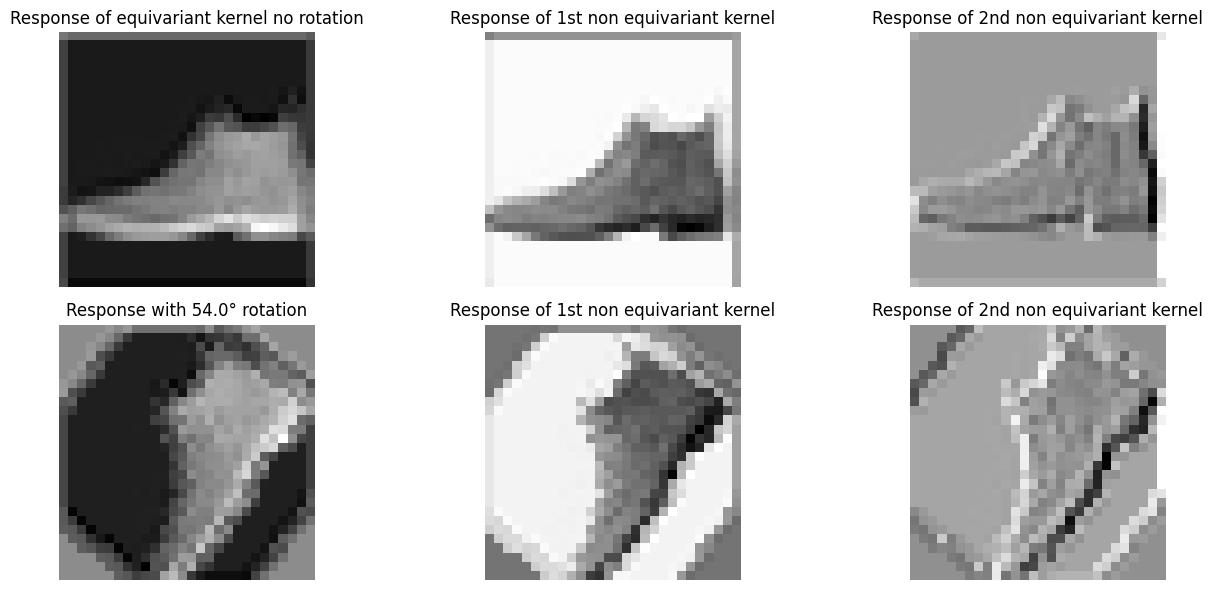

In [ ]:
for im,_ in test_loader:
  image=im[0]
  break

kernels = torch.cat((equivariant_kernel.data.squeeze().unsqueeze(0),non_equivariant_kernel.squeeze())).unsqueeze(1)  # Shape: (3, 1, 3, 3)
# Ensure the image has a batch dimension
test_image = image.unsqueeze(0)  # Shape: (1, 1, 28, 28)
# Perform convolution with each kernel
outputs_tensor = F.conv2d(test_image, kernels, padding=1).squeeze()

angle=np.round(360*torch.rand(1).item())
rotated_image=rotate(test_image,angle)

outputs_rotated_tensor = F.conv2d(rotated_image, kernels, padding=1).squeeze()

fig, ax = plt.subplots(2, 3, figsize=(14, 6))  # 2 rows, 3 columns

# Plot the response on the corresponding axis
ax[0, 0].imshow(outputs_tensor[0, :].numpy(), cmap='gray')
ax[0, 0].set_title(f'Response of equivariant kernel no rotation')
ax[0, 0].axis('off')  # Hide axis ticks for clarity

ax[0, 1].imshow(outputs_tensor[1, :].numpy(), cmap='gray')
ax[0, 1].set_title(f'Response of 1st non equivariant kernel')
ax[0, 1].axis('off')  # Hide axis ticks for clarity

ax[0, 2].imshow(outputs_tensor[2, :].numpy(), cmap='gray')
ax[0, 2].set_title(f'Response of 2nd non equivariant kernel')
ax[0, 2].axis('off')  # Hide axis ticks for clarity


ax[1, 0].imshow(outputs_rotated_tensor[0, :].numpy(), cmap='gray')
ax[1, 0].set_title(f'Response with {int(angle)}° rotation')
ax[1, 0].axis('off')  # Hide axis ticks for clarity

ax[1, 1].imshow(outputs_rotated_tensor[1, :].numpy(), cmap='gray')
ax[1, 1].set_title(f'Response of 1st non equivariant kernel')
ax[1, 1].axis('off')  # Hide axis ticks for clarity

ax[1, 2].imshow(outputs_rotated_tensor[2, :].numpy(), cmap='gray')
ax[1, 2].set_title(f'Response of 2nd non equivariant kernel')
ax[1, 2].axis('off')  # Hide axis ticks for clarity

# Adjust layout and display the plot
plt.tight_layout()
plt.show()